In [1]:
from sklearn.preprocessing import (
    PolynomialFeatures,
    MinMaxScaler)
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    PoissonRegressor
    )
from sklearn.ensemble import (
    RandomForestRegressor
)
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [2]:
full_source,ysource = fetch_openml(data_id=43927,return_X_y=True,as_frame=True)

full_source['Price'] = ysource

full_source['DATE']=pd.to_datetime(
    full_source['month'].astype(int).astype(str)+"/"+
    full_source['day'].astype(int).astype(str)+"/"+
    full_source['year'].astype(int).astype(str)
)

full_source.sort_values(by='DATE',ascending=True,inplace=True)

c:\Users\Jason\Desktop\git_control\ml-research\.venv\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
mask = (full_source['region']=='WestTexNewMexico')&(full_source['type']=='organic')

In [4]:
source = full_source[mask].copy()

source.index = source['DATE'].values

In [29]:

weeks = source['DATE'].dt.isocalendar().week
dates = source['DATE']

def sinu_feat(x,period=1,freq=53,func='sin'):

    if func=='sin':
        f = np.sin
    else:
        f = np.cos

    return f(2*np.pi*period*x/freq)

X = pd.DataFrame()
for f in ['sin','cos']:
    for p in [1,2,3,5,7]:
        X[f"SINU_{f.upper()}_{str(p)}"] = sinu_feat(weeks,period=p,freq=53,func=f)

X['PRICE'] = source['Price'].copy()
X['N'] = range(1,len(X)+1)


y = source['Total Volume'].copy()


In [30]:
train_split = .3

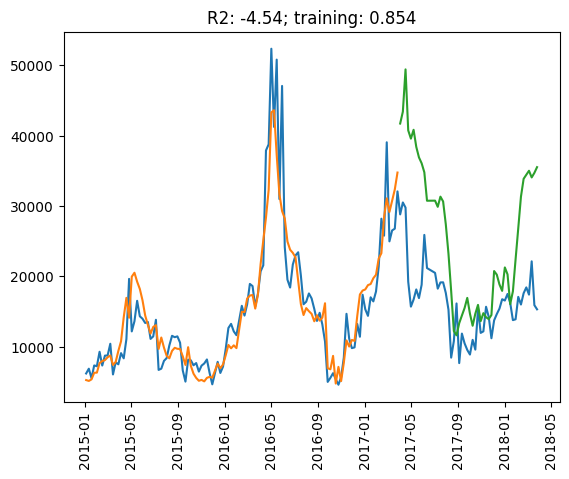

In [31]:
Xtrain,Xtest,ytrain,ytest,dtrain,dtest = train_test_split(X,y,dates,
    test_size=train_split,random_state=42,shuffle=False)


change_points_N = 0

change_points=dtrain[[int(len(dtrain)*(i/(change_points_N+1))) for i in range(1,change_points_N+1)]]

for d in change_points:
    Xtrain[f'change_point_{d}']=np.where(dtrain>=d,1,0)
    Xtest[f'change_point_{d}']=np.where(dtest>=d,1,0)

model = Pipeline(
    steps = [
        #('poly',PolynomialFeatures(degree=1,interaction_only=False)),
        ('scaler',MinMaxScaler()),
        ('learner',PoissonRegressor(alpha=0,max_iter=10000,tol=1e-12)),
        #('learner',RandomForestRegressor(n_estimators=25,min_samples_leaf=5,random_state=42))
    ]
).fit(Xtrain,ytrain)

yfit = pd.Series(model.predict(Xtrain),index = Xtrain.index)
ypred = pd.Series(model.predict(Xtest),index = Xtest.index)

plt.plot(y)
plt.plot(yfit)
plt.plot(ypred)
for d in change_points:
    plt.axvline(x=d, color='r', linestyle='--', label='Vertical Line')
plt.xticks(rotation=90)
plt.title(f"R2: {round(r2_score(y_true=ytest,y_pred=ypred),3)}; training: {round(r2_score(y_true=ytrain,y_pred=yfit),3)}")
plt.show()

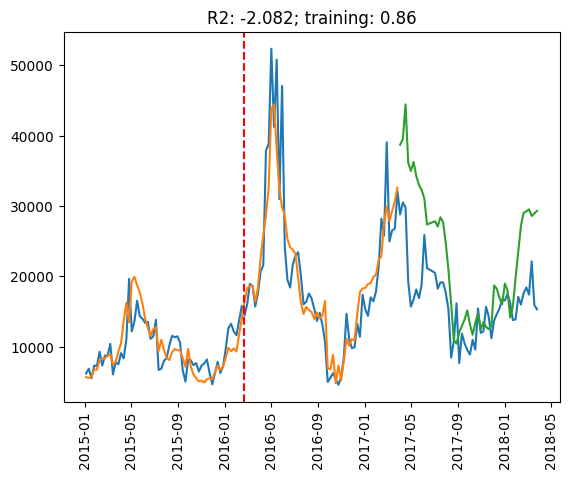

In [32]:
Xtrain,Xtest,ytrain,ytest,dtrain,dtest = train_test_split(X,y,dates,
    test_size=train_split,random_state=42,shuffle=False)


change_points_N = 1

change_points=dtrain[[int(len(dtrain)*(i/(change_points_N+1))) for i in range(1,change_points_N+1)]]

for d in change_points:
    Xtrain[f'change_point_{d}']=np.where(dtrain>=d,1,0)
    Xtest[f'change_point_{d}']=np.where(dtest>=d,1,0)

model = Pipeline(
    steps = [
        #('poly',PolynomialFeatures(degree=1,interaction_only=False)),
        ('scaler',MinMaxScaler()),
        ('learner',PoissonRegressor(alpha=0,max_iter=10000,tol=1e-12)),
        #('learner',RandomForestRegressor(n_estimators=25,min_samples_leaf=5,random_state=42))
    ]
).fit(Xtrain,ytrain)

yfit = pd.Series(model.predict(Xtrain),index = Xtrain.index)
ypred = pd.Series(model.predict(Xtest),index = Xtest.index)

plt.plot(y)
plt.plot(yfit)
plt.plot(ypred)
for d in change_points:
    plt.axvline(x=d, color='r', linestyle='--', label='Vertical Line')
plt.xticks(rotation=90)
plt.title(f"R2: {round(r2_score(y_true=ytest,y_pred=ypred),3)}; training: {round(r2_score(y_true=ytrain,y_pred=yfit),3)}")
plt.show()

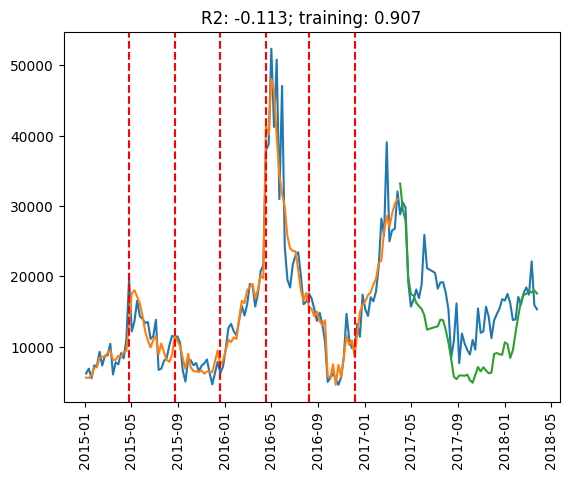

In [33]:
Xtrain,Xtest,ytrain,ytest,dtrain,dtest = train_test_split(X,y,dates,
    test_size=train_split,random_state=42,shuffle=False)


change_points_N = 6

change_points=dtrain[[int(len(dtrain)*(i/(change_points_N+1))) for i in range(1,change_points_N+1)]]

for d in change_points:
    Xtrain[f'change_point_{d}']=np.where(dtrain>=d,1,0)
    Xtest[f'change_point_{d}']=np.where(dtest>=d,1,0)

model = Pipeline(
    steps = [
        #('poly',PolynomialFeatures(degree=1,interaction_only=False)),
        ('scaler',MinMaxScaler()),
        ('learner',PoissonRegressor(alpha=0,max_iter=10000,tol=1e-12)),
        #('learner',RandomForestRegressor(n_estimators=25,min_samples_leaf=5,random_state=42))
    ]
).fit(Xtrain,ytrain)

yfit = pd.Series(model.predict(Xtrain),index = Xtrain.index)
ypred = pd.Series(model.predict(Xtest),index = Xtest.index)

plt.plot(y)
plt.plot(yfit)
plt.plot(ypred)
for d in change_points:
    plt.axvline(x=d, color='r', linestyle='--', label='Vertical Line')
plt.xticks(rotation=90)
plt.title(f"R2: {round(r2_score(y_true=ytest,y_pred=ypred),3)}; training: {round(r2_score(y_true=ytrain,y_pred=yfit),3)}")
plt.show()

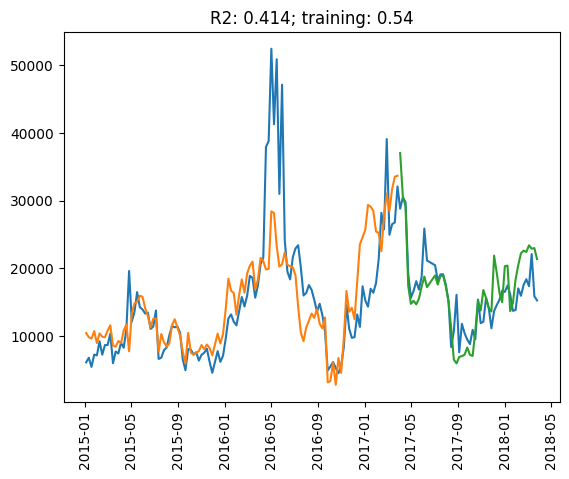

In [43]:

weeks = source['DATE'].dt.isocalendar().week
dates = source['DATE']

X = pd.DataFrame()
for f in ['sin','cos']:
    for p in []:
        X[f"SINU_{f.upper()}_{str(p)}"] = sinu_feat(weeks,period=p,freq=53,func=f)

X['PRICE'] = source['Price'].copy()
X['N'] = range(1,len(X)+1)


y = source['Total Volume'].copy()

Xtrain,Xtest,ytrain,ytest,dtrain,dtest = train_test_split(X,y,dates,
    test_size=train_split,random_state=42,shuffle=False)


change_points_N = 0

change_points=dtrain[[int(len(dtrain)*(i/(change_points_N+1))) for i in range(1,change_points_N+1)]]

for d in change_points:
    Xtrain[f'change_point_{d}']=np.where(dtrain>=d,1,0)
    Xtest[f'change_point_{d}']=np.where(dtest>=d,1,0)

model = Pipeline(
    steps = [
        #('poly',PolynomialFeatures(degree=1,interaction_only=False)),
        ('scaler',MinMaxScaler()),
        ('learner',PoissonRegressor(alpha=0,max_iter=10000,tol=1e-12)),
        #('learner',RandomForestRegressor(n_estimators=25,min_samples_leaf=5,random_state=42))
    ]
).fit(Xtrain,ytrain)

yfit = pd.Series(model.predict(Xtrain),index = Xtrain.index)
ypred = pd.Series(model.predict(Xtest),index = Xtest.index)

plt.plot(y)
plt.plot(yfit)
plt.plot(ypred)
for d in change_points:
    plt.axvline(x=d, color='r', linestyle='--', label='Vertical Line')
plt.xticks(rotation=90)
plt.title(f"R2: {round(r2_score(y_true=ytest,y_pred=ypred),3)}; training: {round(r2_score(y_true=ytrain,y_pred=yfit),3)}")
plt.show()

In [44]:
Xtrain

,PRICE,N
2015-01-04,1.64,1
2015-01-11,1.69,2
2015-01-18,1.71,3
2015-01-25,1.63,4
2015-02-01,1.77,5
...,...,...
2017-02-26,1.16,112
2017-03-05,1.23,113
2017-03-12,1.15,114
2017-03-19,1.11,115


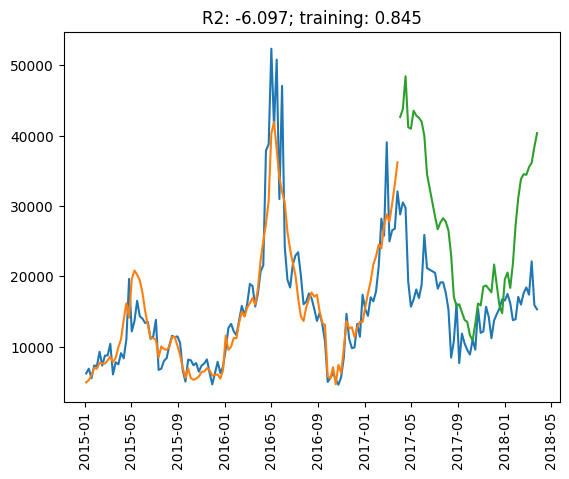

In [40]:

weeks = source['DATE'].dt.isocalendar().week
dates = source['DATE']

X = pd.DataFrame()
for f in ['sin','cos']:
    for p in [1,2,3,.5,.25]:
        X[f"SINU_{f.upper()}_{str(p)}"] = sinu_feat(weeks,period=p,freq=53,func=f)

X['PRICE'] = source['Price'].copy()
X['N'] = range(1,len(X)+1)


y = source['Total Volume'].copy()

Xtrain,Xtest,ytrain,ytest,dtrain,dtest = train_test_split(X,y,dates,
    test_size=train_split,random_state=42,shuffle=False)


change_points_N = 0

change_points=dtrain[[int(len(dtrain)*(i/(change_points_N+1))) for i in range(1,change_points_N+1)]]

for d in change_points:
    Xtrain[f'change_point_{d}']=np.where(dtrain>=d,1,0)
    Xtest[f'change_point_{d}']=np.where(dtest>=d,1,0)

model = Pipeline(
    steps = [
        #('poly',PolynomialFeatures(degree=1,interaction_only=False)),
        ('scaler',MinMaxScaler()),
        ('learner',PoissonRegressor(alpha=0,max_iter=10000,tol=1e-12)),
        #('learner',RandomForestRegressor(n_estimators=25,min_samples_leaf=5,random_state=42))
    ]
).fit(Xtrain,ytrain)

yfit = pd.Series(model.predict(Xtrain),index = Xtrain.index)
ypred = pd.Series(model.predict(Xtest),index = Xtest.index)

plt.plot(y)
plt.plot(yfit)
plt.plot(ypred)
for d in change_points:
    plt.axvline(x=d, color='r', linestyle='--', label='Vertical Line')
plt.xticks(rotation=90)
plt.title(f"R2: {round(r2_score(y_true=ytest,y_pred=ypred),3)}; training: {round(r2_score(y_true=ytrain,y_pred=yfit),3)}")
plt.show()

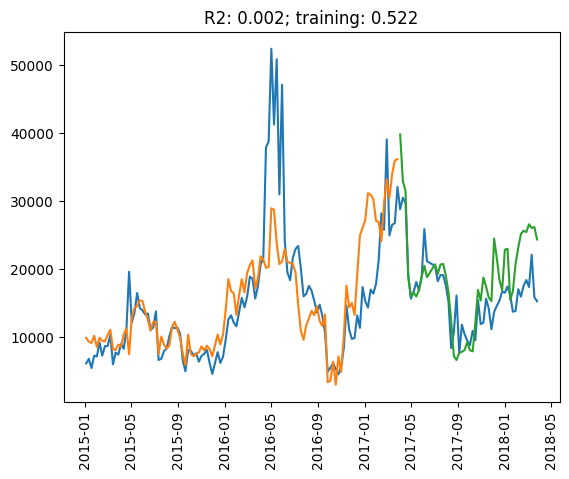

In [66]:
#BV Trade Off

weeks = source['DATE'].dt.isocalendar().week
dates = source['DATE']

X = pd.DataFrame()

X['PRICE'] = source['Price'].copy()
X['N'] = range(1,len(X)+1)

y = source['Total Volume'].copy()

Xtrain,Xtest,ytrain,ytest,dtrain,dtest = train_test_split(X,y,dates,
    test_size=train_split,random_state=42,shuffle=False)

np.random.seed(2)
weights = np.random.binomial(1,p=.7,size=len(Xtrain))

model = Pipeline(
    steps = [
        ('poly',PolynomialFeatures(degree=1,interaction_only=False)),
        ('scaler',MinMaxScaler()),
        ('learner',PoissonRegressor(alpha=0,max_iter=10000,tol=1e-12)),
        #('learner',RandomForestRegressor(n_estimators=25,min_samples_leaf=5,random_state=42))
    ]
).fit(Xtrain,ytrain,learner__sample_weight=weights)

yfit = pd.Series(model.predict(Xtrain),index = Xtrain.index)
ypred = pd.Series(model.predict(Xtest),index = Xtest.index)

plt.plot(y)
plt.plot(yfit)
plt.plot(ypred)
for d in change_points:
    plt.axvline(x=d, color='r', linestyle='--', label='Vertical Line')
plt.xticks(rotation=90)
plt.title(f"R2: {round(r2_score(y_true=ytest,y_pred=ypred),3)}; training: {round(r2_score(y_true=ytrain,y_pred=yfit),3)}")
plt.show()

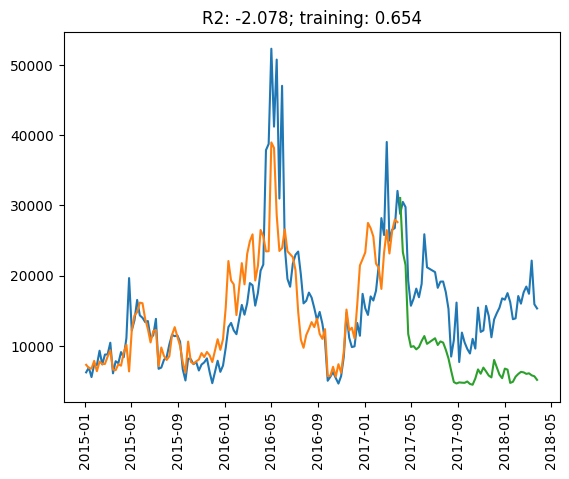

In [53]:

weeks = source['DATE'].dt.isocalendar().week
dates = source['DATE']

X = pd.DataFrame()

X['PRICE'] = source['Price'].copy()
X['N'] = range(1,len(X)+1)

y = source['Total Volume'].copy()

Xtrain,Xtest,ytrain,ytest,dtrain,dtest = train_test_split(X,y,dates,
    test_size=train_split,random_state=42,shuffle=False)

model = Pipeline(
    steps = [
        ('poly',PolynomialFeatures(degree=2,interaction_only=False)),
        ('scaler',MinMaxScaler()),
        ('learner',PoissonRegressor(alpha=0,max_iter=10000,tol=1e-12)),
        #('learner',RandomForestRegressor(n_estimators=25,min_samples_leaf=5,random_state=42))
    ]
).fit(Xtrain,ytrain)

yfit = pd.Series(model.predict(Xtrain),index = Xtrain.index)
ypred = pd.Series(model.predict(Xtest),index = Xtest.index)

plt.plot(y)
plt.plot(yfit)
plt.plot(ypred)
for d in change_points:
    plt.axvline(x=d, color='r', linestyle='--', label='Vertical Line')
plt.xticks(rotation=90)
plt.title(f"R2: {round(r2_score(y_true=ytest,y_pred=ypred),3)}; training: {round(r2_score(y_true=ytrain,y_pred=yfit),3)}")
plt.show()

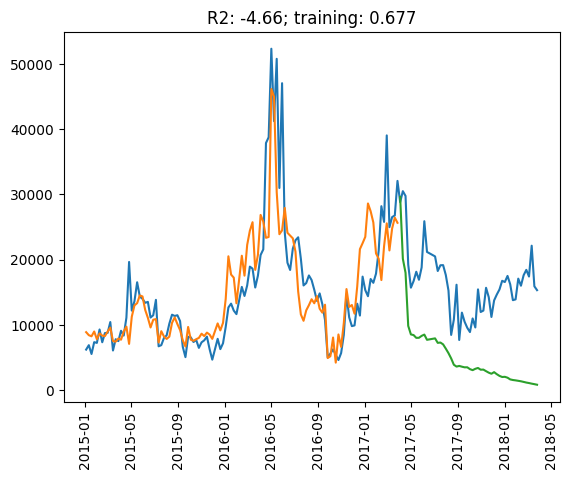

In [54]:

weeks = source['DATE'].dt.isocalendar().week
dates = source['DATE']

X = pd.DataFrame()

X['PRICE'] = source['Price'].copy()
X['N'] = range(1,len(X)+1)

y = source['Total Volume'].copy()

Xtrain,Xtest,ytrain,ytest,dtrain,dtest = train_test_split(X,y,dates,
    test_size=train_split,random_state=42,shuffle=False)

model = Pipeline(
    steps = [
        ('poly',PolynomialFeatures(degree=3,interaction_only=False)),
        ('scaler',MinMaxScaler()),
        ('learner',PoissonRegressor(alpha=0,max_iter=100000,tol=1e-12)),
        #('learner',RandomForestRegressor(n_estimators=25,min_samples_leaf=5,random_state=42))
    ]
).fit(Xtrain,ytrain)

yfit = pd.Series(model.predict(Xtrain),index = Xtrain.index)
ypred = pd.Series(model.predict(Xtest),index = Xtest.index)

plt.plot(y)
plt.plot(yfit)
plt.plot(ypred)
for d in change_points:
    plt.axvline(x=d, color='r', linestyle='--', label='Vertical Line')
plt.xticks(rotation=90)
plt.title(f"R2: {round(r2_score(y_true=ytest,y_pred=ypred),3)}; training: {round(r2_score(y_true=ytrain,y_pred=yfit),3)}")
plt.show()

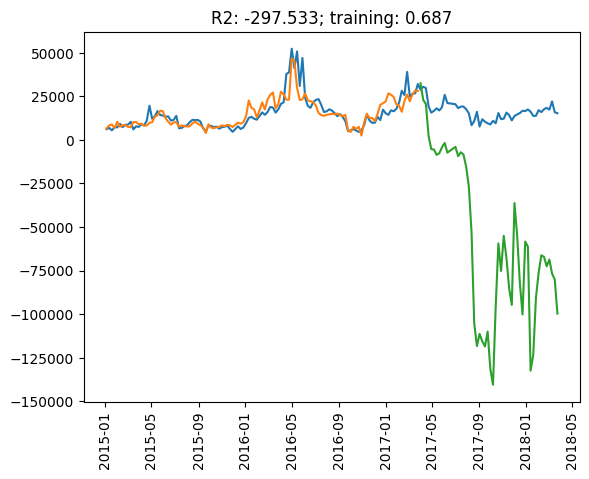

In [50]:

weeks = source['DATE'].dt.isocalendar().week
dates = source['DATE']

X = pd.DataFrame()

X['PRICE'] = source['Price'].copy()
X['N'] = range(1,len(X)+1)

y = source['Total Volume'].copy()

Xtrain,Xtest,ytrain,ytest,dtrain,dtest = train_test_split(X,y,dates,
    test_size=train_split,random_state=42,shuffle=False)

model = Pipeline(
    steps = [
        ('poly',PolynomialFeatures(degree=4,interaction_only=False)),
        ('scaler',MinMaxScaler()),
        ('learner',PoissonRegressor(alpha=0,max_iter=10000,tol=1e-12)),
        #('learner',RandomForestRegressor(n_estimators=25,min_samples_leaf=5,random_state=42))
    ]
).fit(Xtrain,ytrain)

yfit = pd.Series(model.predict(Xtrain),index = Xtrain.index)
ypred = pd.Series(model.predict(Xtest),index = Xtest.index)

plt.plot(y)
plt.plot(yfit)
plt.plot(ypred)
for d in change_points:
    plt.axvline(x=d, color='r', linestyle='--', label='Vertical Line')
plt.xticks(rotation=90)
plt.title(f"R2: {round(r2_score(y_true=ytest,y_pred=ypred),3)}; training: {round(r2_score(y_true=ytrain,y_pred=yfit),3)}")
plt.show()

In [55]:
np.random.seed(0)
weights = np.random.binomial(1,p=.7,size=len(Xtrain))

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1])